# 周末单独

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from sklearn.preprocessing import MinMaxScaler

### mape_choose_func

In [3]:
def mape_func(data, target_date, data_index):
    group_data = data.groupby(by='date')
    target_date = data.loc[target_date].index[1]                 #用于mape的时间
    x_pred = data.loc[target_date, 'load'].values.flatten()
    def mapes(x_true,x_pred =x_pred):
        y = x_true['load'].values.flatten()
        x = x_pred
        mape = np.mean(np.abs(x - y)/x)*100
        return mape
       
    mape_data = group_data.apply(mapes)
    #train_index = mape_data[mape_data<10].index
    
    #train_index = train_index[train_index != target_date]        #让预测数据不会进入模型
    vaild_index = np.array([])
    train_index = np.array([])
    for i in mape_data.sort_values()[1:101].index.sort_values():
        a = i + datetime.timedelta(days=1)
        if a in data_index:
            train_index = np.append(train_index, i)
            vaild_index = np.append(vaild_index, a)
        else:
            continue
    return train_index,vaild_index


### reshape_data_for_train_func

In [4]:
def reshape_data(index_T, index_V, data):
    sc_hour = MinMaxScaler()
    
    data['hour'] = sc_hour.fit_transform(data['hour'].values.reshape(-1,1))
    sc_temp = MinMaxScaler()
    data['temp'] = sc_temp.fit_transform(data['temp'].values.reshape(-1,1))
    sc_load = MinMaxScaler()
    data['load'] = sc_load.fit_transform(data['load'].values.reshape(-1,1))
    length = int(np.floor(index_T.shape[0]*0.8))#######
    print(length,'-------------------------------')
    X_train = data.loc[index_T].iloc[:length*48].values.reshape(-1,48,3)      
    y_train = data.loc[index_V].iloc[:length*48, 2].values.reshape(-1,48)    
    X_test = data.loc[index_T].iloc[length*48:].values.reshape(-1,48,3)
    y_test = data.loc[index_V].iloc[length*48:, 2].values.reshape(-1,48)
    
    #X_train, X_test, y_train, y_test = train_test_split(data.loc[index_T], data.loc[index_V, 'load'], test_size=0.3)
    return [X_train, X_test, y_train, y_test,sc_hour, sc_temp, sc_load]


### Lstm_Cnn_model

In [5]:
def modle_set():
    #建立LSTM模型 训练
    inputs=tf.keras.layers.Input(shape=(48, 3))
    model=tf.keras.layers.Conv1D(filters = 48, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
    #model=tf.keras.layers.Conv1D(filters = 48, kernel_size = 1, activation = 'sigmoid')(model)#卷积层
    model=tf.keras.layers.MaxPooling1D(pool_size = 48, strides=1)(model)#池化层
    #model=tf.keras.layers.Dropout(0.03)(model)#droupout层
    #model=tf.keras.layers.GRU(128, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.Dropout(0.03)(model)
    model=tf.keras.layers.LSTM(48, activation='tanh', return_sequences=True)(model)
    #model=tf.keras.layers.Dropout(0.03)(model)
    model=tf.keras.layers.LSTM(48, activation='tanh')(model)
    outputs = tf.keras.layers.Dense(48)(model)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    model.summary()#展示模型结构
    return model

# main

In [6]:
def mainSet(data, target_date, aim_data, data_index):   
    data_real = data.copy()                                                                           #未归一化的datarale
    
    train_index,vaild_index = mape_func(data, target_date, data_index)
    a = reshape_data(train_index, vaild_index, data)                                                  #会将data     normolization
    
    model = modle_set()
    model.fit(a[0], a[2], epochs = 40, batch_size = 8,shuffle=True,validation_data=(a[1], a[3]))   #训练模型--专属

    for_pred = data.loc[target_date].values.reshape(1,48,3)                                            #用前一天

    pred_data = model.predict(for_pred)                                                                #预测后一天
    pred_data_true = a[-1].inverse_transform(pred_data.reshape(-1,1)).flatten()
    true_value = data_real.loc[aim_data,'load'].values.flatten()                                       #后一天的真实值 
    
    print(target_date, 'to predict', aim_data)
    
    plt.plot(pred_data_true, 'b')
    plt.plot(true_value,'r')
    plt.show()
    
    print('pred')
    print(pred_data_true)
    print('true')
    print(true_value)
    mapes = np.mean(np.abs(true_value - pred_data_true)/true_value)*100
    print('mape:', mapes)
    return pred_data_true,true_value,mapes

# 实验开始

78 -------------------------------
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 3)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 48)            192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 48)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 48)             18624     
_________________________________________________________________
lstm_1 (LSTM)                (None, 48)                18624     
_________________________________________________________________
dense (Dense)                (None, 48)                2352      
Total params: 39,792
Trainable params: 39,792
Non-trainable params: 0
______________________

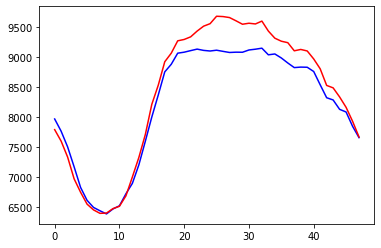

pred
[7968.999  7765.109  7504.578  7174.419  6830.857  6615.8843 6497.634
 6441.519  6389.7305 6472.0913 6524.5674 6723.6646 6898.015  7205.7046
 7598.664  8001.729  8369.23   8752.515  8878.693  9063.7    9080.219
 9106.321  9131.416  9110.094  9099.785  9113.247  9093.91   9075.416
 9080.36   9079.148  9116.885  9129.919  9146.83   9036.51   9050.604
 8984.009  8900.56   8823.872  8832.     8829.664  8758.747  8538.051
 8322.497  8285.488  8129.5693 8085.2197 7847.931  7658.2354]
true
[7791.72 7599.79 7335.43 6974.33 6750.34 6552.65 6456.53 6399.15 6403.65
 6477.61 6516.86 6689.41 7004.54 7329.24 7710.77 8212.53 8532.27 8920.78
 9063.29 9269.28 9291.95 9335.5  9431.41 9512.85 9554.45 9678.17 9672.74
 9656.15 9602.31 9545.2  9561.83 9549.93 9597.34 9431.27 9313.16 9262.74
 9238.52 9103.25 9125.77 9100.48 8967.81 8803.87 8527.43 8486.77 8335.69
 8163.02 7931.6  7669.42]
mape: 2.6205771233958055


In [7]:
data = pd.read_csv('week.csv', index_col=['date'], parse_dates=['date'])
data_index = data.index.unique()
pred,true,mape = mainSet(data, '2010-11-12', '2010-11-13', data_index)

In [25]:
targ_list = ['2010-11-05', '2010-11-06', '2010-11-12', 
             '2010-11-13', '2010-11-19', '2010-11-20',
             '2010-11-26', '2010-11-27']
aim_list = ['2010-11-06', '2010-11-07', '2010-11-13', 
             '2010-11-14', '2010-11-20', '2010-11-21',
             '2010-11-27', '2010-11-28']

73 -------------------------------
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 48, 3)]           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 48, 48)            192       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1, 48)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 1, 48)             18624     
_________________________________________________________________
lstm_15 (LSTM)               (None, 48)                18624     
_________________________________________________________________
dense_6 (Dense)              (None, 48)                2352      
Total params: 39,792
Trainable params: 39,792
Non-trainable params: 0
____________________

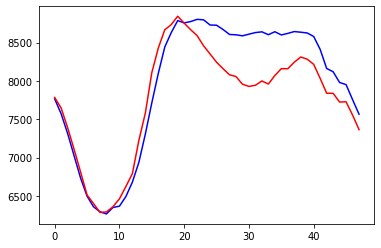

pred
[7765.827  7571.1694 7315.1626 7024.387  6733.6123 6498.254  6358.9604
 6293.3237 6266.1323 6349.7495 6366.9004 6493.0513 6680.61   6938.298
 7306.321  7713.8467 8096.944  8440.879  8629.641  8786.311  8755.799
 8773.798  8802.621  8795.966  8728.457  8725.798  8670.102  8605.558
 8601.059  8587.891  8609.207  8630.066  8639.7295 8602.412  8640.956
 8599.467  8619.361  8643.326  8634.889  8624.867  8578.991  8410.293
 8162.0205 8119.308  7979.496  7951.535  7756.497  7565.6353]
true
[7783.96 7646.12 7390.75 7107.84 6812.95 6513.24 6400.92 6286.04 6291.83
 6359.52 6462.75 6623.78 6791.3  7223.99 7579.43 8107.61 8427.65 8666.25
 8734.14 8842.97 8752.87 8667.34 8589.88 8456.93 8350.84 8243.41 8158.73
 8080.14 8056.93 7956.93 7928.44 7942.94 7999.56 7959.4  8069.97 8160.03
 8158.53 8243.42 8312.03 8283.33 8215.54 8032.39 7839.28 7837.97 7724.35
 7727.79 7555.09 7364.88]
mape: 3.547652765488389
54 -------------------------------
Model: "model_7"
________________________________________

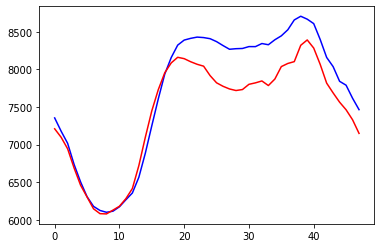

pred
[7354.687  7178.048  7017.842  6736.7573 6505.366  6308.9233 6179.941
 6125.6226 6101.5376 6115.847  6174.3213 6268.0435 6357.676  6566.471
 6886.442  7250.876  7607.282  7936.8325 8156.8223 8321.918  8388.71
 8411.772  8428.28   8421.989  8407.209  8368.272  8315.698  8266.756
 8274.277  8277.342  8302.287  8301.824  8342.786  8326.943  8392.76
 8445.064  8525.369  8656.137  8705.359  8666.374  8607.563  8397.025
 8158.34   8036.05   7840.9785 7789.4395 7616.4927 7464.648 ]
true
[7210.23 7097.46 6944.89 6689.52 6461.3  6304.55 6147.68 6083.15 6079.75
 6130.11 6181.53 6282.79 6417.29 6721.75 7098.29 7448.86 7730.09 7954.27
 8085.83 8160.05 8142.03 8101.08 8067.25 8042.15 7916.85 7821.24 7774.89
 7739.43 7718.78 7731.77 7801.17 7820.4  7845.88 7784.93 7870.86 8036.68
 8078.03 8102.46 8319.75 8390.47 8282.81 8066.75 7817.01 7686.87 7563.9
 7463.13 7330.59 7149.39]
mape: 3.5372516517081882
78 -------------------------------
Model: "model_8"
___________________________________________

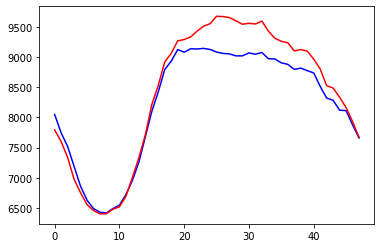

pred
[8049.11   7742.4937 7518.308  7188.2754 6857.489  6626.203  6487.263
 6425.748  6416.03   6488.1885 6543.9414 6719.14   6954.6045 7256.743
 7676.99   8098.9165 8425.504  8793.635  8933.123  9125.429  9082.3
 9138.708  9134.962  9144.731  9127.305  9084.144  9061.053  9053.228
 9020.194  9021.631  9069.334  9048.535  9076.662  8973.47   8969.555
 8905.374  8880.241  8796.44   8817.646  8775.926  8738.073  8515.123
 8321.376  8283.91   8119.1865 8112.8486 7876.5044 7659.084 ]
true
[7791.72 7599.79 7335.43 6974.33 6750.34 6552.65 6456.53 6399.15 6403.65
 6477.61 6516.86 6689.41 7004.54 7329.24 7710.77 8212.53 8532.27 8920.78
 9063.29 9269.28 9291.95 9335.5  9431.41 9512.85 9554.45 9678.17 9672.74
 9656.15 9602.31 9545.2  9561.83 9549.93 9597.34 9431.27 9313.16 9262.74
 9238.52 9103.25 9125.77 9100.48 8967.81 8803.87 8527.43 8486.77 8335.69
 8163.02 7931.6  7669.42]
mape: 2.6657787579356302
63 -------------------------------
Model: "model_9"
__________________________________________

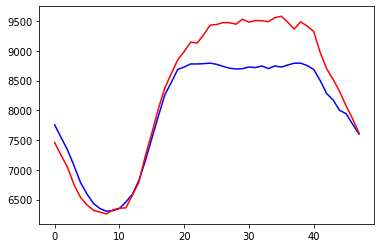

pred
[7754.5586 7540.014  7331.025  7064.718  6782.772  6591.0894 6432.85
 6346.556  6303.178  6312.5107 6348.8545 6458.809  6587.7593 6816.439
 7150.2603 7525.3257 7897.489  8257.723  8465.606  8685.965  8727.932
 8779.5    8779.128  8783.892  8792.975  8772.948  8738.618  8707.461
 8694.912  8700.231  8728.665  8718.062  8745.082  8701.248  8745.466
 8726.39   8762.285  8791.823  8792.487  8751.132  8686.952  8500.981
 8281.924  8173.3057 7999.3555 7944.2446 7768.258  7599.175 ]
true
[7456.31 7242.75 7037.92 6746.96 6533.8  6406.54 6318.   6287.17 6257.72
 6325.66 6353.46 6358.96 6572.41 6790.08 7232.65 7614.35 8022.6  8372.98
 8614.88 8848.65 8986.17 9146.39 9130.96 9268.2  9431.47 9442.76 9475.23
 9471.7  9447.39 9531.49 9481.04 9509.25 9505.98 9490.18 9556.68 9581.36
 9479.4  9367.15 9488.12 9413.52 9326.18 8973.37 8699.58 8518.79 8317.63
 8076.06 7858.04 7617.99]
mape: 4.305947729845055
72 -------------------------------
Model: "model_10"
_________________________________________

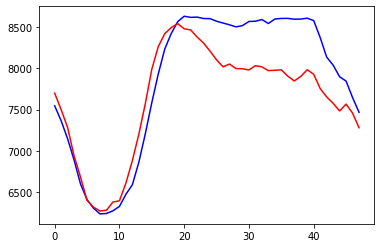

pred
[7545.682  7363.9497 7144.338  6886.276  6594.0596 6405.497  6301.238
 6232.189  6237.373  6270.038  6322.9546 6470.6313 6586.6973 6861.051
 7206.473  7584.079  7932.485  8235.324  8423.334  8567.821  8633.484
 8619.895  8622.909  8605.865  8604.364  8572.799  8550.917  8529.564
 8504.721  8519.7    8570.037  8572.601  8593.482  8545.27   8599.875
 8606.8    8607.645  8597.538  8599.196  8609.932  8580.806  8375.119
 8137.506  8039.7773 7898.2646 7845.573  7645.8623 7466.743 ]
true
[7698.96 7498.86 7281.45 6936.39 6676.8  6396.83 6314.37 6267.42 6277.04
 6376.66 6391.01 6606.38 6879.9  7200.98 7572.37 7989.62 8264.51 8421.6
 8495.47 8544.23 8481.18 8466.99 8380.54 8307.48 8208.27 8103.64 8019.13
 8052.48 7998.17 7995.55 7981.04 8033.03 8018.03 7973.22 7977.28 7982.32
 7905.84 7847.67 7901.97 7984.08 7928.23 7755.08 7653.65 7576.1  7483.01
 7566.4  7456.93 7278.91]
mape: 4.344723745819904
42 -------------------------------
Model: "model_11"
_________________________________________

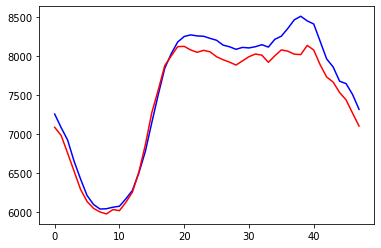

pred
[7260.7983 7086.9565 6927.086  6655.7026 6427.5923 6216.854  6101.358
 6042.736  6046.8315 6066.2046 6078.8774 6174.501  6280.7485 6505.746
 6780.3193 7151.207  7510.835  7848.068  8034.2847 8184.682  8254.86
 8275.511  8262.37   8258.09   8230.896  8206.618  8144.5664 8123.532
 8090.647  8115.094  8108.5005 8124.089  8149.8657 8119.183  8219.126
 8258.861  8357.954  8468.579  8514.636  8454.918  8415.74   8192.541
 7967.2495 7864.885  7681.746  7650.7505 7511.73   7320.8613]
true
[7090.83 6986.06 6760.39 6527.12 6294.61 6139.96 6051.96 6005.29 5980.31
 6036.   6021.97 6129.97 6259.3  6515.63 6865.08 7278.56 7571.23 7880.97
 8005.78 8125.06 8128.52 8082.69 8052.26 8077.55 8058.23 7995.52 7957.18
 7926.25 7888.81 7942.18 7995.95 8030.31 8015.66 7924.17 8007.57 8083.29
 8066.84 8028.86 8022.77 8140.54 8081.94 7891.74 7735.92 7670.76 7536.78
 7442.11 7272.63 7106.86]
mape: 2.091420032492411
80 -------------------------------
Model: "model_12"
_________________________________________

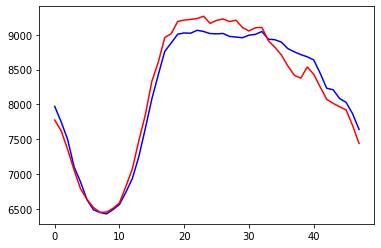

pred
[7972.241  7749.931  7496.4644 7101.618  6884.3906 6626.198  6483.371
 6445.341  6424.5747 6485.634  6559.392  6737.0513 6934.568  7250.081
 7653.5664 8076.239  8426.496  8763.479  8884.092  9010.333  9027.6455
 9024.061  9066.427  9048.834  9019.341  9014.738  9020.394  8978.092
 8968.819  8959.292  8995.626  9007.768  9048.525  8938.433  8930.684
 8896.084  8802.929  8756.721  8716.723  8684.3545 8640.961  8448.966
 8233.453  8210.419  8085.4595 8029.4614 7867.0107 7640.0977]
true
[7775.14 7621.58 7352.58 7055.24 6785.56 6631.69 6515.74 6447.65 6450.86
 6504.6  6583.8  6820.93 7074.62 7480.55 7848.92 8329.09 8608.05 8961.58
 9017.24 9193.34 9212.99 9222.8  9235.72 9268.29 9166.05 9208.1  9229.47
 9191.43 9211.02 9105.96 9056.33 9102.75 9107.86 8917.   8822.83 8712.19
 8554.41 8419.46 8377.18 8537.98 8434.52 8251.53 8073.58 8015.31 7965.3
 7921.39 7696.89 7437.95]
mape: 1.7946705054688747
66 -------------------------------
Model: "model_13"
_______________________________________

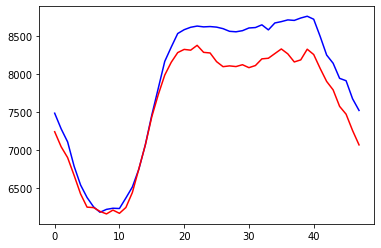

pred
[7483.0737 7277.655  7105.4136 6786.3228 6539.0913 6374.6514 6252.0327
 6180.376  6218.3486 6233.055  6229.7227 6368.5    6512.9287 6747.241
 7067.5186 7458.8267 7811.063  8164.5654 8352.013  8530.62   8581.122
 8612.839  8628.646  8618.083  8622.316  8614.89   8594.618  8559.74
 8553.359  8568.122  8603.657  8609.269  8645.009  8578.468  8669.484
 8687.151  8709.737  8703.169  8734.677  8757.913  8718.662  8492.145
 8247.684  8139.7705 7941.296  7910.0015 7673.15   7519.1895]
true
[7239.79 7042.03 6899.01 6665.75 6421.44 6247.71 6241.86 6191.66 6158.63
 6208.94 6166.45 6243.24 6440.46 6751.08 7064.03 7437.11 7727.5  7984.53
 8152.66 8279.98 8321.88 8311.75 8375.56 8283.17 8275.1  8161.08 8094.9
 8105.09 8096.23 8120.49 8081.84 8109.79 8197.5  8205.53 8266.91 8327.65
 8263.45 8156.93 8184.06 8324.47 8254.33 8071.07 7900.53 7789.66 7572.89
 7470.29 7255.79 7066.29]
mape: 3.654601853453309


In [26]:
pred = np.array([])
true = np.array([])
mape_values = []
for i, j in zip(targ_list, aim_list):  
    data = pd.read_csv('week.csv', index_col=['date'], parse_dates=['date'])
    data_index = data.index.unique()
    pred_data_true, true_value, mapes=mainSet(data, i, j, data_index)
    pred = np.append(pred, pred_data_true)
    true = np.append(true, true_value)
    mape_values.append(mapes)

In [17]:
preds = pd.DataFrame(pred.reshape(-1,48), columns=[str(x) + 'h' for x in range(1,49)], index=aim_list)
preds.to_csv('weekend_pred_11.csv')
trues = pd.DataFrame(true.reshape(-1,48), columns=[str(x) + 'h' for x in range(1,49)], index=aim_list)
trues.to_csv('weekend_true_11.csv')
pd.DataFrame(np.array(mape_values).reshape(-1,1),columns=['mape'],index=aim_list).to_csv('weekend_mape_11.csv')

In [ ]:
11-06
[7740.145  7533.6123 7308.216  7019.2173 6736.153  6504.6753 6378.1646
 6301.1626 6289.567  6322.21   6376.1836 6518.0176 6692.584  6943.5444
 7293.0537 7698.9233 8039.855  8370.547  8555.597  8724.861  8739.178
 8749.81   8733.606  8699.705  8678.569  8653.649  8614.037  8563.552
 8557.795  8544.532  8569.772  8584.778  8611.29   8540.912  8596.675
 8589.631  8608.714  8618.832  8642.339  8629.302  8554.615  8356.728
 8149.324  8071.481  7921.0703 7902.838  7707.13   7533.0825]
11-07
[7331.1963 7155.02   6999.447  6723.6123 6476.87   6302.8306 6158.6304
 6140.726  6118.0654 6173.478  6186.581  6240.787  6382.38   6535.5615
 6917.155  7257.42   7623.8154 7946.506  8186.095  8329.718  8373.898
 8412.538  8433.148  8389.969  8338.056  8307.402  8276.927  8192.811
 8222.98   8212.817  8208.592  8271.038  8280.896  8237.193  8359.055
 8397.18   8484.611  8540.786  8671.182  8595.236  8515.355  8292.702
 8098.5947 7961.8525 7792.197  7740.5176 7518.0005 7418.269 ]

11-13
[7949.6055 7763.6616 7490.787  7117.3823 6830.6597 6602.6294 6505.7993
 6462.3643 6434.418  6483.1255 6553.9224 6728.348  6928.922  7206.8774
 7601.81   8012.257  8379.388  8677.176  8888.395  8983.441  9024.59
 9064.292  9066.453  9018.255  9058.833  9018.151  9007.259  9004.002
 8989.17   8975.78   8993.78   9019.889  9067.563  8912.479  8950.632
 8852.544  8803.404  8685.477  8731.926  8713.405  8682.451  8479.637
 8275.642  8187.7983 8048.029  8046.598  7793.5723 7630.804 ]

11-20
[7522.951  7448.803  7173.2324 6902.3545 6670.95   6425.069  6306.022
 6292.367  6098.251  6241.176  6449.8667 6578.5767 6676.8916 6881.604
 7325.685  7572.0986 7948.6333 8333.791  8498.637  8623.384  8554.38
 8608.205  8608.621  8594.367  8455.8    8496.838  8534.671  8461.357
 8503.314  8566.788  8532.351  8669.547  8612.073  8473.168  8568.032
 8553.083  8484.835  8457.316  8553.071  8727.591  8541.871  8461.447
 8123.304  8045.842  7801.916  7728.0786 7498.4165 7545.256 ]
11-21
[7274.6255 7079.9814 6891.7153 6657.337  6427.483  6237.067  6127.2617
 6032.0635 6077.6704 6059.3506 6129.4507 6203.64   6351.1626 6575.444
 6831.3096 7215.97   7568.4653 7919.656  8094.394  8230.21   8304.208
 8334.686  8318.455  8339.678  8326.112  8246.088  8189.913  8218.3545
 8140.3984 8129.208  8166.09   8149.234  8180.4194 8210.129  8256.4
 8332.12   8366.253  8486.204  8546.4795 8462.837  8421.698  8250.23
 8007.5615 7866.9395 7714.5757 7673.7114 7530.148  7340.605 ]

11-27
[7916.6333 7739.107  7514.7114 7074.88   6740.561  6661.2095 6432.3887
 6454.423  6460.854  6477.625  6538.182  6673.5957 6928.575  7200.8164
 7535.499  8069.2295 8373.867  8709.848  8937.392  8993.448  8952.566
 9032.723  9026.151  9039.706  9018.085  9033.589  8927.67   8950.511
 8815.78   8880.22   8961.703  8831.424  8940.275  8869.71   8774.931
 8771.788  8760.317  8626.699  8593.128  8642.615  8552.86   8425.226
 8286.255  8175.4746 7942.41   7994.326  7768.89   7626.8994]

11-28

[7397.6987 7287.9043 7057.1846 6810.9277 6486.597  6369.472  6245.1655
 6258.4136 6252.3306 6238.4746 6286.681  6376.233  6420.6177 6768.2656
 7087.564  7402.183  7691.1    8157.741  8337.436  8525.091  8538.178
 8606.452  8590.862  8610.537  8611.445  8562.285  8573.144  8507.924
 8531.719  8491.569  8604.579  8517.543  8561.208  8558.835  8642.471
 8750.91   8660.929  8661.795  8663.156  8704.969  8687.237  8406.933
 8244.296  8119.5723 7928.726  7813.802  7644.386  7485.4756]